In [1]:
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from modules import train_model, test_model
from dataset import BPDataset, MIMICDataset, DMDataset
from torch import optim
from torch.optim import lr_scheduler
from datetime import datetime
import pandas as pd
from backbone_models import ResNet18, VGG16, shallowResNet, shallowResNet2,ResNet3, FCNet, Conv3Net
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
ppg_dir = '/Users/yeseullee/Documents/ECE271B/PPGBPDatabase/Data File/0_subject'
label_path = '/Users/yeseullee/Documents/ECE271B/PPGBPDatabase/Data File/PPG-BP dataset.csv'

In [3]:
##Calculate Dataset's mean and std for normalization - Before preprocessed
'''temp_dataset=MIMICDataset(data_path, label_path,choose_class=[0,1,2])
temp_size=temp_dataset.__len__()
temp_dataloader=torch.utils.data.DataLoader(temp_dataset,batch_size=temp_size,shuffle=False)
for data, label, sub in temp_dataloader:
    flatten_data=np.array(data.flatten())
    mean=np.mean(flatten_data)
    std=np.std(flatten_data)
    print('- mean: ',mean)
    print('- std: ',std)'''

"temp_dataset=MIMICDataset(data_path, label_path,choose_class=[0,1,2])\ntemp_size=temp_dataset.__len__()\ntemp_dataloader=torch.utils.data.DataLoader(temp_dataset,batch_size=temp_size,shuffle=False)\nfor data, label, sub in temp_dataloader:\n    flatten_data=np.array(data.flatten())\n    mean=np.mean(flatten_data)\n    std=np.std(flatten_data)\n    print('- mean: ',mean)\n    print('- std: ',std)"

In [4]:
##Calculate Dataset's mean and std for normalization - After preprocessed
'''temp_dataset=MIMICDataset(data_path, label_path,normalize=None, preprocessing=True, choose_class=[0,1,2])
temp_size=temp_dataset.__len__()
temp_dataloader=torch.utils.data.DataLoader(temp_dataset,batch_size=temp_size,shuffle=False)
for data, label, sub in temp_dataloader:
    flatten_data=np.array(data.flatten())
    mean=np.mean(flatten_data)
    std=np.std(flatten_data)
    print('- mean: ',mean)
    print('- std: ',std)'''

"temp_dataset=MIMICDataset(data_path, label_path,normalize=None, preprocessing=True, choose_class=[0,1,2])\ntemp_size=temp_dataset.__len__()\ntemp_dataloader=torch.utils.data.DataLoader(temp_dataset,batch_size=temp_size,shuffle=False)\nfor data, label, sub in temp_dataloader:\n    flatten_data=np.array(data.flatten())\n    mean=np.mean(flatten_data)\n    std=np.std(flatten_data)\n    print('- mean: ',mean)\n    print('- std: ',std)"

In [5]:
data_mean=2060.61
data_std=285.13
data_normalization = {'mean':data_mean,'std':data_std}

# setup data loader
dataset = DMDataset(ppg_dir, label_path, normalize=data_normalization,preprocessing=False)
dataset_size=dataset.__len__()
print('dataset: {}'.format(dataset.__len__()))

dataset: 648


In [6]:
training_size=int(dataset_size*0.64)
test_size=int(dataset_size*0.2)
val_size=dataset_size-training_size-test_size

In [7]:
# Split training data, validation data, testing data
data_train, data_val, data_test = torch.utils.data.random_split(dataset, [training_size, val_size, test_size])
print(data_train.__len__())
print(data_val.__len__())
print(data_test.__len__())

414
105
129


In [8]:
73/341

0.21407624633431085

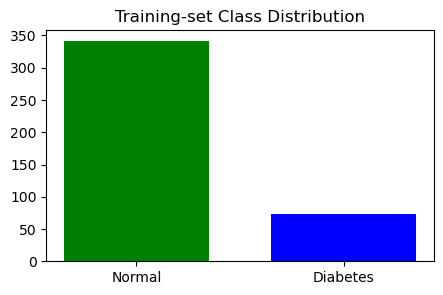

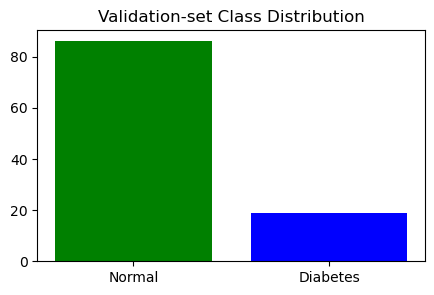

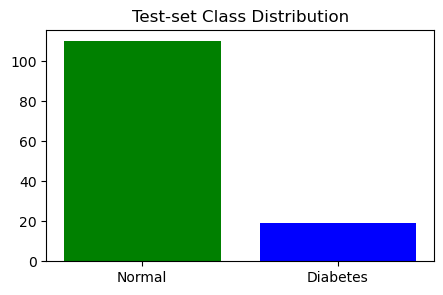

In [9]:
temp_dataloaders={'train': torch.utils.data.DataLoader(data_train,batch_size=1,shuffle=False),
                'val':torch.utils.data.DataLoader(data_val,batch_size=1,shuffle=False),
                'test':torch.utils.data.DataLoader(data_test,batch_size=1,shuffle=False)}

train_labels=[0,0]
for data, label, subject in temp_dataloaders['train']:
    if label.data==0:
        train_labels[0]+=1
    elif label.data==1:
        train_labels[1]+=1

plt.figure(figsize=(5,3))
plt.bar(np.arange(2),train_labels,color=['g','b'],width=0.7)
plt.xticks(np.arange(2),['Normal','Diabetes'])
plt.title('Training-set Class Distribution')
plt.show()

val_labels=[0,0]
for data, label, subject in temp_dataloaders['val']:
    if label.data==0:
        val_labels[0]+=1
    elif label.data==1:
        val_labels[1]+=1

plt.figure(figsize=(5,3))
plt.bar(np.arange(2),val_labels,color=['g','b'])
plt.xticks(np.arange(2),['Normal','Diabetes'])
plt.title('Validation-set Class Distribution')
plt.show()

test_labels=[0,0]
for data, label, subject in temp_dataloaders['test']:
    if label.data==0:
        test_labels[0]+=1
    elif label.data==1:
        test_labels[1]+=1

plt.figure(figsize=(5,3))
plt.bar(np.arange(2),test_labels,color=['g','b'])
plt.xticks(np.arange(2),['Normal','Diabetes'])
plt.title('Test-set Class Distribution')
plt.show()

In [10]:
dataloaders={'train': torch.utils.data.DataLoader(data_train,batch_size=16,shuffle=True),
                'val':torch.utils.data.DataLoader(data_val,batch_size=16,shuffle=True),
                'test':torch.utils.data.DataLoader(data_test,batch_size=16,shuffle=False)}
dataset_sizes = {'train': data_train.__len__(),
                    'val':data_val.__len__(),
                    'test':data_test.__len__()}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:',device)

Device: cpu


In [41]:
class Conv3Net2(nn.Module):
    def __init__(self, n_class=2):
        super(Conv3Net2, self).__init__()
        self.n_class = n_class
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=30, stride=3, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=15, stride=3, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=7),
            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            #nn.MaxPool1d(kernel_size=7)
            nn.AdaptiveAvgPool1d(1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, n_class)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [42]:
model=Conv3Net2(2)
#model.load_state_dict(torch.load('/Users/yeseullee/Documents/ECE271B/project/models/shallowPPG_[0,2]_03-22-14:15.pt'))
model.load_state_dict(torch.load('/Users/yeseullee/Documents/ECE271B/project/models/shallowPPG_MIMIC[0,2]_03-20-10:45.pt'))
model=model.to(device)

Epoch 0/179
----------
train Loss: 0.8562 Acc: 0.5411
val Loss: 0.7094 Acc: 0.7238

Epoch 1/179
----------
train Loss: 0.7139 Acc: 0.6353
val Loss: 0.6663 Acc: 0.8190

Epoch 2/179
----------
train Loss: 0.6804 Acc: 0.6787
val Loss: 0.7183 Acc: 0.8190

Epoch 3/179
----------
train Loss: 0.6690 Acc: 0.7585
val Loss: 0.6423 Acc: 0.6952

Epoch 4/179
----------
train Loss: 0.6790 Acc: 0.6329
val Loss: 0.6251 Acc: 0.7429

Epoch 5/179
----------
train Loss: 0.6883 Acc: 0.6667
val Loss: 0.6719 Acc: 0.5619

Epoch 6/179
----------
train Loss: 0.6729 Acc: 0.7995
val Loss: 0.6507 Acc: 0.8286

Epoch 7/179
----------
train Loss: 0.6584 Acc: 0.7295
val Loss: 0.6508 Acc: 0.8190

Epoch 8/179
----------
train Loss: 0.6744 Acc: 0.7367
val Loss: 0.6976 Acc: 0.8190

Epoch 9/179
----------
train Loss: 0.6808 Acc: 0.7705
val Loss: 0.6666 Acc: 0.8190

Epoch 10/179
----------
train Loss: 0.6585 Acc: 0.7947
val Loss: 0.6284 Acc: 0.7143

Epoch 11/179
----------
train Loss: 0.6720 Acc: 0.7101
val Loss: 0.6383 Acc

train Loss: 0.5460 Acc: 0.7633
val Loss: 0.6352 Acc: 0.7714

Epoch 98/179
----------
train Loss: 0.5660 Acc: 0.7971
val Loss: 0.6261 Acc: 0.6857

Epoch 99/179
----------
train Loss: 0.5454 Acc: 0.7729
val Loss: 0.6371 Acc: 0.7810

Epoch 100/179
----------
train Loss: 0.5595 Acc: 0.8043
val Loss: 0.6099 Acc: 0.6381

Epoch 101/179
----------
train Loss: 0.5961 Acc: 0.7657
val Loss: 0.6262 Acc: 0.7333

Epoch 102/179
----------
train Loss: 0.5462 Acc: 0.7899
val Loss: 0.6200 Acc: 0.6667

Epoch 103/179
----------
train Loss: 0.5491 Acc: 0.7198
val Loss: 0.6264 Acc: 0.7429

Epoch 104/179
----------
train Loss: 0.5483 Acc: 0.8213
val Loss: 0.6089 Acc: 0.7143

Epoch 105/179
----------
train Loss: 0.5569 Acc: 0.7367
val Loss: 0.6213 Acc: 0.7333

Epoch 106/179
----------
train Loss: 0.5719 Acc: 0.7923
val Loss: 0.6111 Acc: 0.7810

Epoch 107/179
----------
train Loss: 0.5647 Acc: 0.7923
val Loss: 0.6174 Acc: 0.7524

Epoch 108/179
----------
train Loss: 0.5641 Acc: 0.8213
val Loss: 0.6270 Acc: 0.7

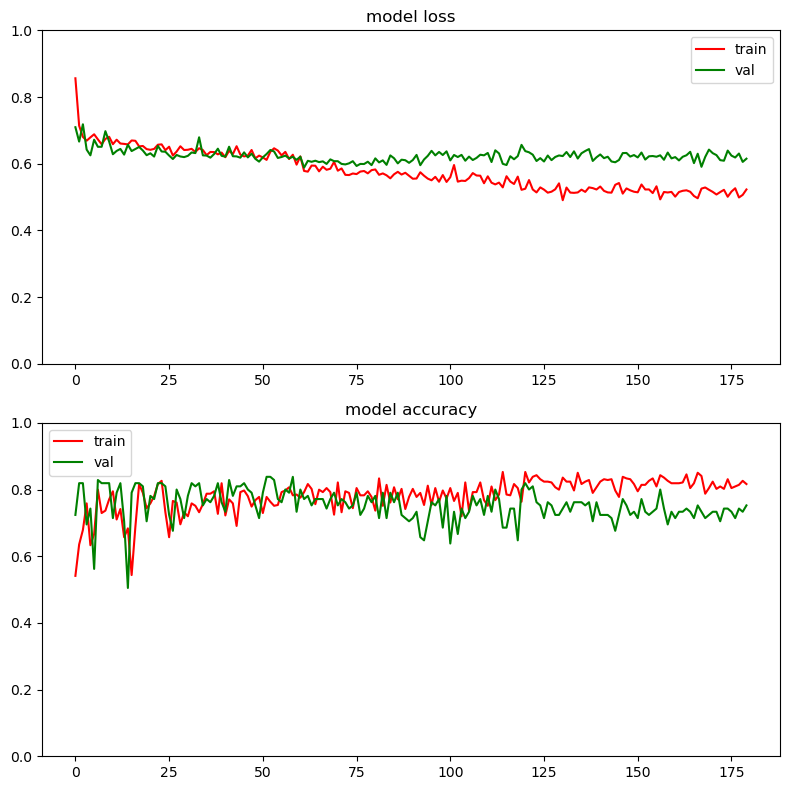

In [43]:
#learning_rate=0.001
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor([0.2,0.8]))
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.001)
#optimizer = optim.Adam(model.parameters(), lr=learning_rate) #weight_decay=0.01
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=60, gamma=0.1)
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.2)
trained_model,trained_model_later=train_model(model, criterion, optimizer, exp_lr_scheduler, dataloaders, dataset_sizes, device, num_epochs=180)

In [40]:
from sklearn.metrics import confusion_matrix

def test_model(model,dataloaders,dataset_size,classes,device):
    
    model=model.to(device)
    model.eval()
    corrects=0
    CM=0
    with torch.no_grad():
        for data in dataloaders['test']:
            images, labels, subject= data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images) 
            preds = torch.argmax(outputs.data, 1)

            cm_tmp=confusion_matrix(labels.tolist(), preds.tolist(),labels=classes)
            CM+=cm_tmp
            
            corrects += torch.sum(preds == labels.data)
        tn=CM[0][0]
        tp=CM[1][1]
        fp=CM[0][1]
        fn=CM[1][0]
        
        sensitivity=tp/(tp+fn)
        precision=tp/(tp+fp)    
        acc=corrects.double() / dataset_size
        
        print('\nTestset Accuracy(mean): %f %%' % (100 * acc))
        print('Confusion Matrix: ')
        print(CM)
        print('- Sensitivity : ',(tp/(tp+fn))*100)
        print('- Specificity : ',(tn/(tn+fp))*100)
        print('- Precision: ',(tp/(tp+fp))*100)
        print('- NPV: ',(tn/(tn+fn))*100)
        print('- F1 : ',((2*sensitivity*precision)/(sensitivity+precision))*100)
                
    return acc, CM

device_cpu=torch.device('cpu')

print('- model')
acc1,cm1=test_model(trained_model,dataloaders,dataset_sizes['test'],classes=[0,1], device=device)

print('- model_later')
acc2,cm2=test_model(trained_model_later,dataloaders,dataset_sizes['test'],classes=[0,1], device=device)

- model

Testset Accuracy(mean): 84.496124 %
Confusion Matrix: 
[[108   2]
 [ 18   1]]
- Sensitivity :  5.263157894736842
- Specificity :  98.18181818181819
- Precision:  33.33333333333333
- NPV:  85.71428571428571
- F1 :  9.090909090909092
- model_later

Testset Accuracy(mean): 82.170543 %
Confusion Matrix: 
[[105   5]
 [ 18   1]]
- Sensitivity :  5.263157894736842
- Specificity :  95.45454545454545
- Precision:  16.666666666666664
- NPV:  85.36585365853658
- F1 :  8.0


In [58]:
CM=[[101,8],[13,5]]
tn=CM[0][0]
tp=CM[1][1]
fp=CM[0][1]
fn=CM[1][0]
sensitivity=tp/(tp+fn)
precision=tp/(tp+fp)    
acc=(tn+tp) / (tn+tp+fp+fn)

print('\nTestset Accuracy(mean): %f %%' % (100 * acc))
print('Confusion Matrix: ')
print(CM)
print('- Sensitivity : ',(tp/(tp+fn))*100)
print('- Specificity : ',(tn/(tn+fp))*100)
print('- Precision: ',(tp/(tp+fp))*100)
print('- NPV: ',(tn/(tn+fn))*100)
print('- F1 : ',((2*sensitivity*precision)/(sensitivity+precision))*100)


Testset Accuracy(mean): 83.464567 %
Confusion Matrix: 
[[101, 8], [13, 5]]
- Sensitivity :  27.77777777777778
- Specificity :  92.66055045871559
- Precision:  38.46153846153847
- NPV:  88.59649122807018
- F1 :  32.25806451612903


In [51]:
CM[0][0]

108

In [58]:
model_path='/Users/yeseullee/Documents/ECE271B/project/models/'
model_name='shallowPPG_MIMIC_DM_transfer_'
torch.save(trained_model.state_dict(),model_path+model_name+datetime.today().strftime('%m-%d-%H:%M')+'.pt')

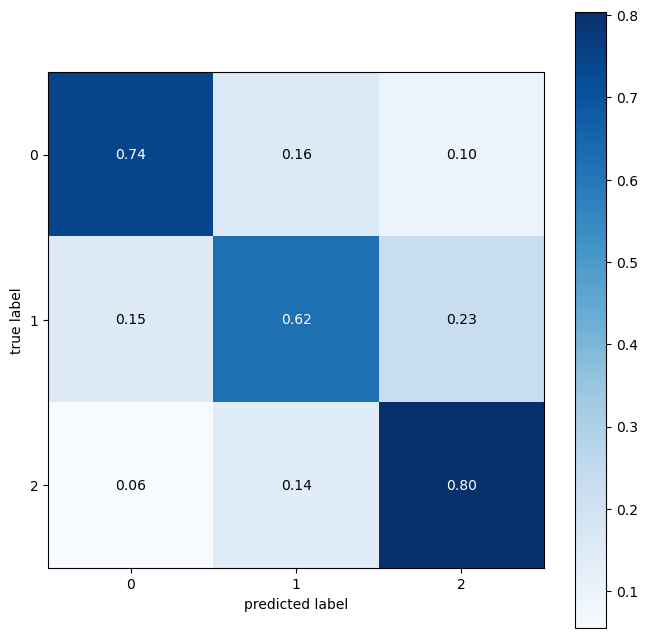

In [64]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as npa

multiclass = np.array([[24915, 5262, 3313],
                       [4855, 20049, 7444],
                       [2205, 5625, 32097]])

fig, ax = plot_confusion_matrix(conf_mat=multiclass,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True)
plt.show()

In [62]:
!pip install mlxtend

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 4.1 MB/s eta 0:00:0000:0100:010m
